In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from ae import Autoencoder
import torch.nn as nn
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL image to tensor and scale to [0, 1]
])

## Downloading the MNIST dataset

In [3]:
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load the MNIST test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,          # Load test set
    download=True,
    transform=transform
)

## Creating dataloaders and displaying sample image

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verify the download by printing some info
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Visualize a sample image
sample_image, sample_label = train_dataset[0]  # Get the first image and label
print(f"Sample image shape: {sample_image.shape}")  # Should be [1, 28, 28]
print(f"Sample label: {sample_label}")

Training set size: 60000
Test set size: 10000
Sample image shape: torch.Size([1, 28, 28])
Sample label: 5


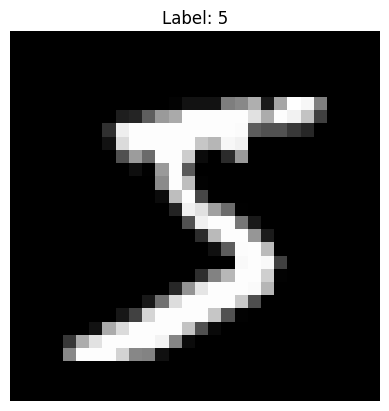

In [5]:
# Plot the sample image
plt.imshow(sample_image.squeeze(), cmap='gray')  # Squeeze removes the channel dim for plotting
plt.title(f"Label: {sample_label}")
plt.axis('off')  # Hide axes
plt.show()

## Declarations

In [6]:
from encoder import Encoder
from decoder import Decoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

convChannels = (1, 4, 4, 4, 4)
convKernels =   (3, 3, 2, 2)
convStrides =   (1, 1, 2, 2)
convPadding =   (1, 1, 0, 0)

# AutoEncoder
ae = Autoencoder(2, sample_image.shape, convChannels, convKernels, convStrides, convPadding).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

## Main Training Loop

In [7]:
losses = []
iterations = []
max_epochs = 50

ae.train()
for epoch in range(max_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Move images to GPU
        images = images.to(device)

        # Forward and backward pass
        optimizer.zero_grad()
        outputs = ae(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        if i == 0:
            print(f"Epoch: {epoch}, Loss: {loss.detach()}")

print(f"Final Loss: {loss.detach()}")

Epoch: 0, Loss: 0.21837878227233887
Epoch: 1, Loss: 0.06027180328965187
Epoch: 2, Loss: 0.05865766853094101
Epoch: 3, Loss: 0.05572625994682312
Epoch: 4, Loss: 0.05544879287481308
Epoch: 5, Loss: 0.0530305877327919
Epoch: 6, Loss: 0.04992024600505829
Epoch: 7, Loss: 0.051829610019922256
Epoch: 8, Loss: 0.04959375783801079
Epoch: 9, Loss: 0.04800812155008316
Epoch: 10, Loss: 0.04939984157681465
Epoch: 11, Loss: 0.049841586500406265
Epoch: 12, Loss: 0.04919928312301636
Epoch: 13, Loss: 0.045341309159994125
Epoch: 14, Loss: 0.04723767563700676
Epoch: 15, Loss: 0.0462837778031826
Epoch: 16, Loss: 0.04820989817380905
Epoch: 17, Loss: 0.053112808614969254
Epoch: 18, Loss: 0.0463249497115612
Epoch: 19, Loss: 0.04913775995373726
Epoch: 20, Loss: 0.05007213354110718
Epoch: 21, Loss: 0.04934424161911011
Epoch: 22, Loss: 0.051013119518756866
Epoch: 23, Loss: 0.047399528324604034
Epoch: 24, Loss: 0.04899057000875473
Epoch: 25, Loss: 0.053425922989845276
Epoch: 26, Loss: 0.048367712646722794
Epoch:

## Displaying Examples

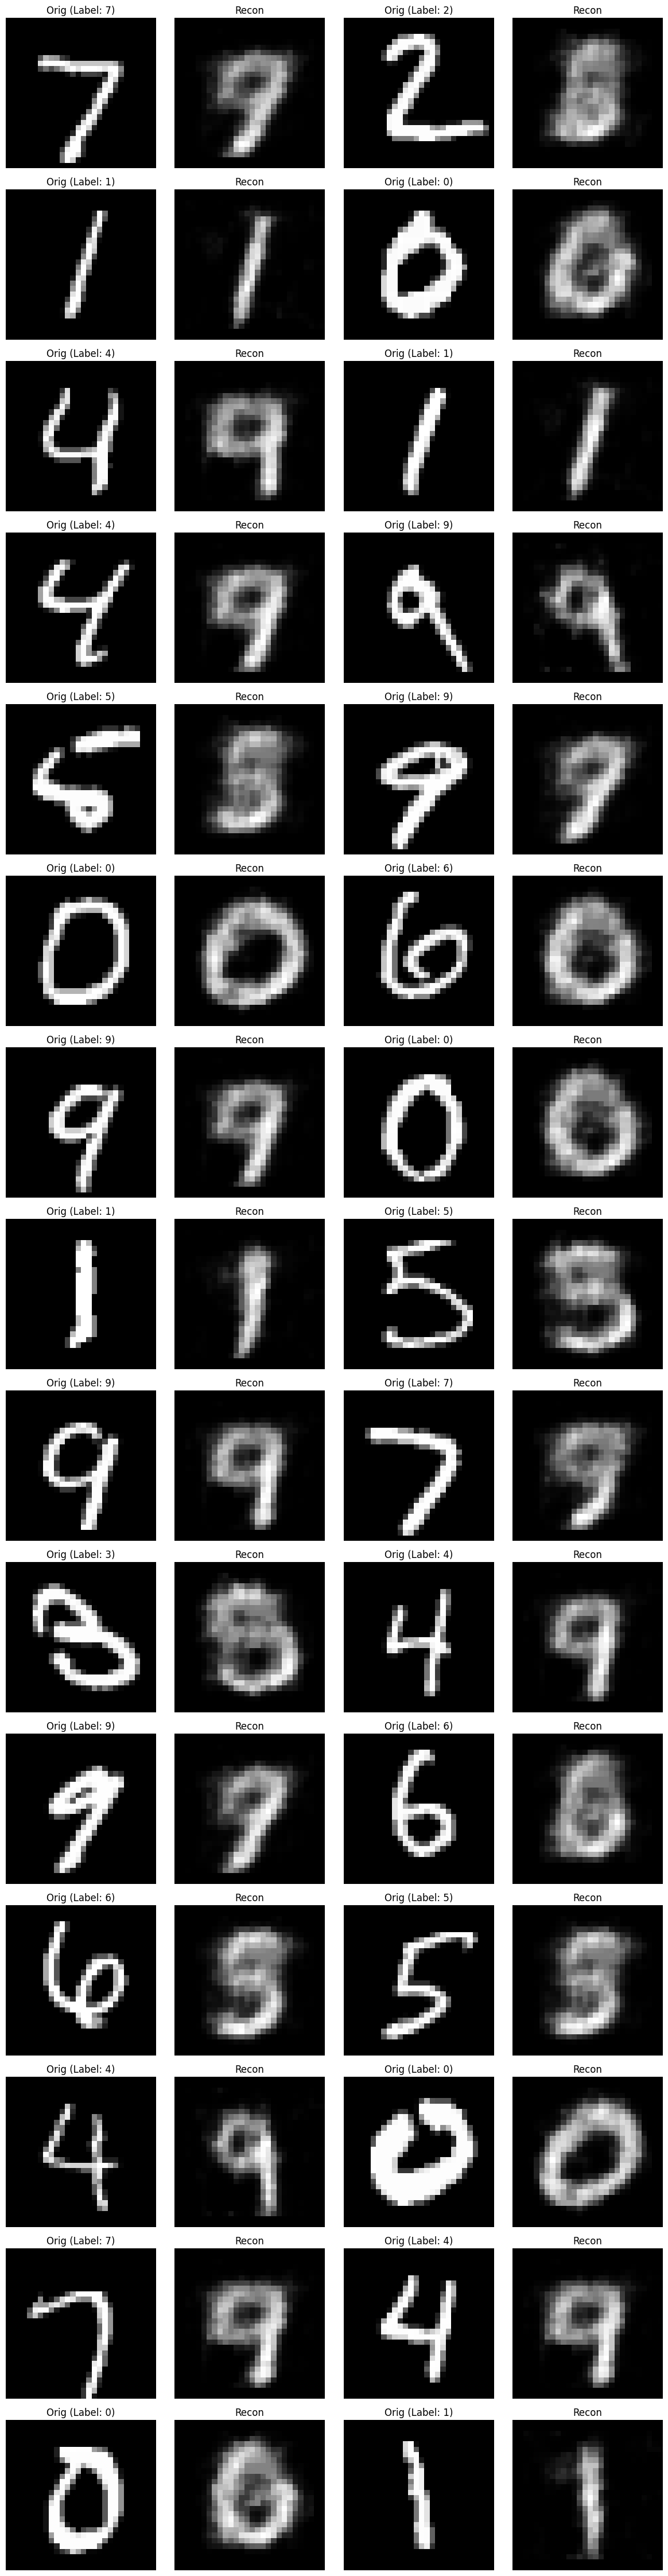

In [8]:
# Assuming ae, test_dataset, and device are already defined
num_examples = 30
pairs_per_row = 2  # Two pairs (4 images) per row
rows = (num_examples + pairs_per_row - 1) // pairs_per_row  # Ceiling division: 2 rows for 5 examples

ae.eval()

with torch.no_grad():
    # Create a figure with rows and 4 columns
    fig, axes = plt.subplots(rows, 4, figsize=(12, 3 * rows))  # 4 columns for 2 pairs
    
    for i in range(num_examples):
        # Calculate row and column indices
        row_idx = i // pairs_per_row
        pair_idx = i % pairs_per_row
        col_idx = pair_idx * 2  # 0 or 2 for each pair’s original

        # Get the original image and label
        image, label = test_dataset[i]
        image = image.to(device).unsqueeze(dim=0)

        # Get the reconstructed image
        reconstructed_image = ae(image)

        # Move to CPU and squeeze
        image = image.squeeze().to('cpu')
        reconstructed_image = reconstructed_image.squeeze().to('cpu')

        # Plot original image
        axes[row_idx, col_idx].imshow(image, cmap='gray')
        axes[row_idx, col_idx].set_title(f"Orig (Label: {label})")
        axes[row_idx, col_idx].axis('off')

        # Plot reconstructed image
        axes[row_idx, col_idx + 1].imshow(reconstructed_image, cmap='gray')
        axes[row_idx, col_idx + 1].set_title("Recon")
        axes[row_idx, col_idx + 1].axis('off')

    # Hide empty subplots (if num_examples doesn’t fill all columns)
    for i in range(num_examples, rows * pairs_per_row):
        row_idx = i // pairs_per_row
        col_idx = (i % pairs_per_row) * 2
        axes[row_idx, col_idx].axis('off')      # Hide original slot
        axes[row_idx, col_idx + 1].axis('off')  # Hide reconstructed slot

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

## Visualizing Latent Space

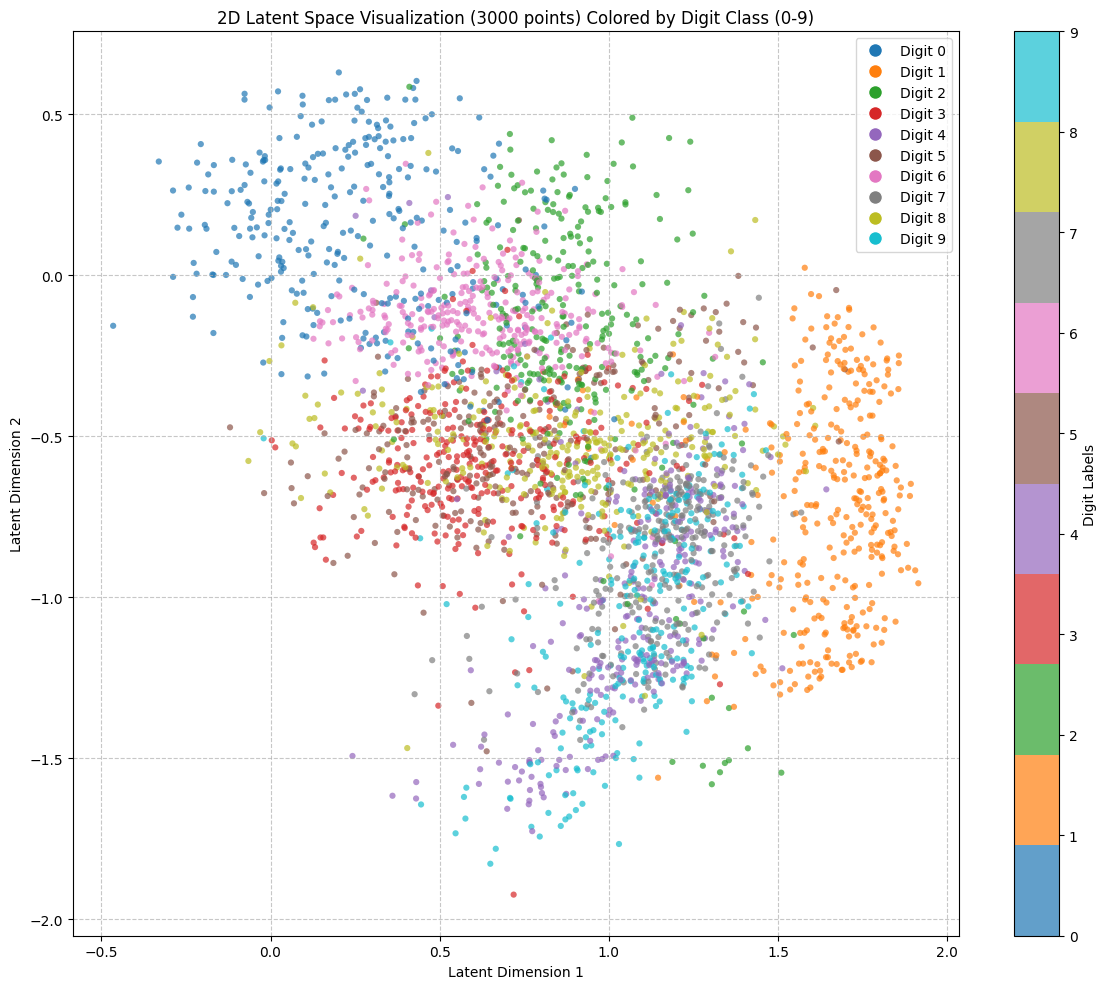

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to collect latent vectors and labels from multiple batches
def collect_latents(model, data_loader, device, num_samples=3000):
    all_latents = []
    all_labels = []
    samples_collected = 0
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for images, labels in data_loader:
            if samples_collected >= num_samples:
                break
                
            # Move batch to device
            images = images.to(device)
            
            # Get encodings
            _ = model(images)
            batch_latents = model.latent
            
            # Move to CPU and convert to numpy
            batch_latents_np = batch_latents.cpu().numpy()
            batch_labels_np = labels.cpu().numpy()
            
            # Collect only what we need to reach num_samples
            remaining = num_samples - samples_collected
            if len(batch_labels_np) > remaining:
                batch_latents_np = batch_latents_np[:remaining]
                batch_labels_np = batch_labels_np[:remaining]
            
            all_latents.append(batch_latents_np)
            all_labels.append(batch_labels_np)
            samples_collected += len(batch_labels_np)
            
    # Combine all batches
    latents_np = np.vstack(all_latents)
    labels_np = np.concatenate(all_labels)
    
    return latents_np, labels_np

# Collect ~3000 points
latents_np, labels_np = collect_latents(ae, train_loader, device, num_samples=3000)

# Set up the plot
plt.figure(figsize=(12, 10))

# Create a scatter plot with points colored by digit label
scatter = plt.scatter(latents_np[:, 0], latents_np[:, 1], 
                     c=labels_np, alpha=0.7, s=20, 
                     cmap='tab10', edgecolors='none')

# Add color bar to show the mapping of colors to digit labels
cbar = plt.colorbar(scatter, ticks=np.arange(10))
cbar.set_label('Digit Labels')

# Add labels and title
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization (3000 points) Colored by Digit Class (0-9)')

# Add a legend with digit classes
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=scatter.cmap(scatter.norm(i)), 
                             markersize=10, label=f'Digit {i}') 
                 for i in range(10)]
plt.legend(handles=legend_elements, loc='best')

# Display the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()